We are interested in formulating output feedback controllers that use the dynamics of implicit surface representations to find control inputs.  We'd like to be able to verify these controllers via the safety verification method (or something close to that) described in Barry, Majumdar, Tedrake *(2012)*.

Consider a known function $s$ which maps from $[-\frac{\theta_{FOV}}{2},\frac{\theta_{FOV}}{2}]$ to the distance of a UAV, where $S_{max}$ is the moving maximum sensing horizon of the sensor.

$$s: [-\frac{\theta_{FOV}}{2},\frac{\theta_{FOV}}{2}] \rightarrow [0,S_{max}] $$

We like $s$ as a continous function since then we avoid having a hybrid system.  (What do we call a non-hybrid system?)

The distance $s$ may also be thought of as the Euclidean distance from the $0$-level-set of the signed distance function (SDF) for the set of obstacles.  A side-effect benefit of this approach is that we can naturally use implicit surface representations produced by fusion algorithms of depth sensor information (i.e. Kinect Fusion, etc.)

What we need to find is a geometric PDE somewhat of the form:

$$ \frac{\partial}{\partial t}  s(\theta)  = f(s,\psi, u(s))$$



Where $\psi$ is the yaw of the UAV and $u$ is some control input.  The $f$ will contain partial derivatives and may be thought of as an operator. that may be calculated via a reactive controller, for example of the form:

$$ u = k_1\int w_1(\theta)s(\theta)d\theta + k_2\int w_s(\theta)s(\theta)d\theta$$

We need to use a finite dimensional space to approximate the function $s$.

Given some vector of basis functions $\mathbf{w}$ (maybe polynomial basis?) and vector of weights $\mathbf{c}$ we can approximate $s$ as:

$$ s(\theta) \approx c_1w_1(\theta) + c_2w_2(\theta) + ... + c_Nw_n(\theta) $$

Which then gives us a PDE that approximates $f$:

$$ \frac{\partial}{\partial t} s(\theta) \approx \dot{c}_1w_1(\theta) + \dot{c}_2w_2(\theta) + ... + \dot{c}_Nw_N(\theta) $$

$$ \approx f(\psi, u(s))$$

We can now instead think of $f$ as a vector $\mathbf{f}$ which is a function $\mathbf{f}(c_0,c_1,...,c_N,\theta,\dot{\psi)}$, and whose elements are $f_1, f_2, ..., f_N$.  Also write $\mathbf{c}$ as the vector $\mathbf{c} = (c_1,c_2,...,c_N)$.  

We now have an ODE for the weights:

$$ \frac{d}{d t} \mathbf{c} = \begin{pmatrix}
        f_1(\mathbf{c}, \dot{\psi}) \\
        f_2(\mathbf{c}, \dot{\psi}) \\
        \vdots \\
        f_N(\mathbf{c}, \dot{\psi}) \\
        \end{pmatrix} $$



### Assumptions of the environment

Will always assume that there is an obstacle wherever we cannot see.

Can also assume that there are obstacles immediately beyond our maximum sensor distance.

### Memory of environment

We would like to be able to deal with the issue of seeing something, then turning away from it, but being able to remember it was there.  

One way to be able to do this is to have our basis functions defined over the entire domain $[0,2\pi]$.  This generalizes easily to when we have sensors that can see a full 360 degrees. For sensors with limited FOVs, we should make sure our basis functions decay rapidly near the edges.

It is possible that we may naturally impose *memory leakage* if our basis functions cause information outside of our FOV to be naturaly drawn down farther.  One option would be to regularize basis functions outside of the FOV.

### Choice of basis functions

A polynomial basis would naturally lead to SOS.  It may be unclear, however, to know how to stay away from the weights $\textbf{c}$ of polynomial bases.  (It is not clear how each $c_i$ should indicate where obstacles are).

An easy choice of basis functions would be step functions, but then we would worry about hybrid dynamics.

A similar choice but one the preserves continuity is radial basis functions.  Gaussian radial basis functions seem to be a fine choice.  Ani thinks we can still do SOS with linear combinations of Gaussians.

Options:

- polynomials
- trig polynomials
- linear combinations of Gaussians
- inverse quadratic $\phi(r) = \frac{1}{1 + (\epsilon r)^2} $

Set of basis functions needs to be:

- closed under addition
- closed under scaling
- closed under multiplication

Ani says we can only have up to 12 or 13 basis functions if we're going to use SOS.

Research question: can we do distributed SOS?  Hard to parallelize? ...


**Periodic over 2$\pi$**

It is possible that we won't need functions that are periodic over the unit circle.  It's possible that although the ODE approximation to the PDE will leak out of the unit circle, it might be slow enough that we don't care.  Could try just regular Gaussian radial basis functions.

But perhaps better to have a function that is indeed periodic over the unit circle, so that if we do a 360 degree turn, we end up with the same parameterization of obstacles in front of us.

What I think we want is to have functions that have a uni-modal, tunably sharp peak over the unit circle.  We basically want Gaussian radial basis functions, but ones that are periodic with period $2\pi$.

How can we get those functions?

Do a Fourier transform over the Gaussian radial basis function over $[0,2\pi]$.  Pick some number of terms for this basis function.  Although there are multiple terms, their relative weighting stays the same.  Only the weighting of the entire basis function becomes an element in $\mathbf{c}$



### Image space vs. 2D

What is nice about thinking in image space is that we just define distances to obstacles as a function of one variable.

If we think in 2D, then it is more similar to the signed distance function representation.

### Controller synthesis

Want to maximize some property of $\mathbf{c} \in \mathbb{R}^n$ (where $n = $ # of basis functions) that corresponds to the size of the safety-verified set of conditions $\mathbf{c}_{t=0}$.

The easiest is to imagine a linear combination:

$$u=\mathbf{K} \cdot \mathbf{c} $$.  

Where $\mathbf{K}^{1 \times n}, \mathbf{c}^{n \times 1}$. We can either hand-design $K$ or we can search for a $K$ that maximizes the safety-verified set over $\mathbf{c}$.

There are a few different ideas of what property to maximize.

1. Maximize volume.  For this, we may need to bound $\mathbf{c}_{t=0}$ as $\{\mathbf{c}_{t=0} \in [0, S_{max}] \subset \mathbb{R}^n\}$ (Ani says not known how to do with SOS).
2. Maximize the minimum $c_min$.  For this, we may want to choose only a subset $c_{i:j}$ where $i,...,j$ represent the coefficients of the basis functions in the middle in front of us, only the ones that we care about not hitting. (Ani says may be possible with SOS).
3. Maximize some sphere around a point in $R^n$. May again only want to think about $R^k$ where $k = j - i$. (Ani says can do with SOS).

Each element of $\mathbf{K}$ would be a decision variable our optimization. 

## Simple 2D, fixed position, rotation-only with a 2D laser scanner

Believe that our PDE is:

$$ \frac{\partial s}{\partial t} = \frac{\partial s}{\partial \theta} \dot{\psi} $$

Where $s(\theta,t)$ is the distance to an obstacle at time $t$ and angle $\theta$, and $\dot{\psi}$ is the rate of rotation of the vehicle.  If we assume that we can directly control the rate of change, then $u = \dot{\psi}$ and we have:

$$ \frac{\partial s}{\partial t} = \frac{\partial s}{\partial \theta} u $$


**Questions**

- How to use SDFs?
- Why use image space rather than project out into 2D / 3D?
- Getting to SOS?

- How do we define what is an obstacle, in terms of $\mathbf{c}$?

- How do we synthesize a controller?

- Look up Galerkin approximation?  Turn a PDE into an ODE of basis function coefficients?


**Ani's recommendations to implement**

- See if the ODE approximation to the PDE actually works well.  Should be able to integrate forward my ODE, and also just simulate my dynamics in the specific implementation of some world, and see how well they match.  Integrate forward with n=10 basis functions.
- Pick some small ball, make sure can verify with some hand-designed controllers.  Start with 2 basis functions.


13.0
-0.77780687436
10.4403065089
-0.0227024708811


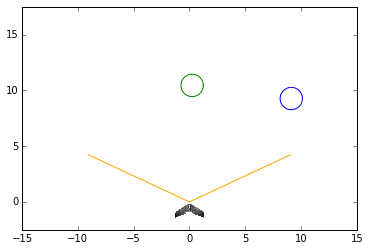

In [1]:
import IPython.html.widgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from planeVis import plotPlane
theta_slider = widgets.FloatSlider(min=-90, max=90, step=1, value=0)

w=widgets.interactive(plotPlane,theta_deg=theta_slider)
display(w)